# Classifieur SVM
Les machines à vecteurs performent bien lorsque les données ont beaucoup de dimensions, surtout comparé au perceptron ou à la classification logistique. Comme c'est le cas de notre ensemble de données, on s'est dit que ça valait la peine d'essayer.

De plus, la technique du SVM permet d'utiliser des noyaux non linéaires pour classifier des données non-linéairement séparables (ce qu'on suppose être le cas pour notre ensemble de données).

In [1]:
import DataManagement as DM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC

dataset = DM.Dataset('data/train.csv')
dataset.split_data(test_size=0.3, seed=0, stratified=True)
dataset.info()

(693, 192) (297, 192)
##### Informations #####
  - Nb classes   : 99 ( Dim : 192 )
  - Nb samples   : 990
     - Training  : 693 ( 70.0 % )
     - Test      : 297 ( 30.0 % )
########################


Puisque qu'on a beaucoup de classe et très peu de données par classe, on a séparé notre ensemble de données de façon à avoir autant de données dans chaque classe.

## Entrainement

Pour notre classifieur SVM, on considère les 3 hyperparamètres suivant :
- Un paramètre de régularisation (C)
- Le noyau : linéaire, gaussien, polynomial ou sigmoidal
- Un paramètre gamma utilisé pour les noyaux gaussien, polynomial et sigmoidal : soit scale, soit auto

L'hyperparamètre le plus important est évidemment le noyau choisit. Le meilleur noyau dépend beaucoup de la forme de nos données, mais comme elles ont trop de dimension pour qu'on puisse les visualiser, on doit le trouver par recherche d'hyperparamètre.

On suspecte aussi que le paramètre de régularisation aura une forte influence sur les performances du modèle, mais celui-ci devrait être indépendant du noyau choisit.

### Recherche du degré du noyau polynomial

Le noyau polynomial possède un hyperparamètre supplémentaire important : le degré. Comme rechercher le degré optimal en même temps que les autres hyperparamètres prendrait trop de temps, on le fait séparément.

Dans la recherche du degré optimal, on inclut aussi le paramètre de régularisation au cas où il aurait une influence sur les performances. Cependant, comme on suspecte que son influence soit petite, on limite le nombre de valeur recherchée.

In [2]:
steps = 1
hyperparameters = {
    'C': [steps + steps*i for i in range(0, 10)],
    'degree': range(1,6)
}

grid, results = DM.train_model(SVC(kernel='poly'), hyperparameters, dataset)
print('Best:', grid.best_params_, 'with score {:.3}'.format(grid.best_score_))

best_degree = grid.best_params_['degree']

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best: {'C': 6, 'degree': 1} with score 0.916


On peut afficher les résultats dans un graphique pour mieux voir l'impact des hyperparamètres sur les performances du modèle.

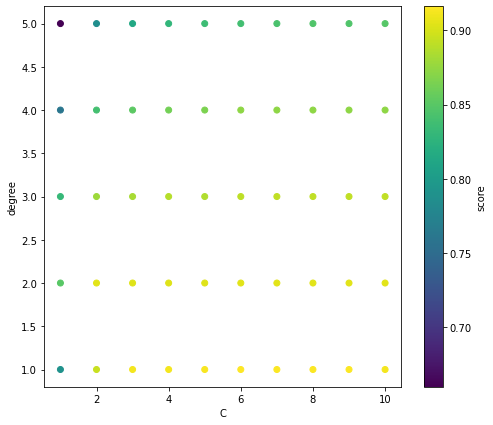

In [3]:
# Figure 1
plt.figure(figsize=(8,7))

plt.scatter(results.param_C, results.param_degree, c=results.mean_test_score)

plt.xlabel('C')
plt.ylabel('degree')
plt.colorbar(label='score')

plt.show()

On peut voir les performances sont croissantes avec le paramètre de régularisation, presqu'indépendemment du degré du noyau polynomiale. Cependant, les performances sont toujours meilleures avec un degré de 1, peu importe le paramètre de régulatisation. La seule exception étant lorsque C=1.

Le degré optimal du noyau polynomial est donc 1.

### Recherche des hyperparamètres

Pour la vrai recherche des hyperparamètres, on fixe le degré du noyau polynomial à la valeur optimale trouvée précédemment.

Pour cette recherche, on inclut aussi plus de valeur du paramètre de régularisation parce que cette fois-ci on cherche sa valeur optimale.

In [4]:
steps = 0.5
hyperparameters = {
    'C': [steps + steps*i for i in range(0, 20)],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

grid, results = DM.train_model(SVC(degree=best_degree), hyperparameters, dataset)
print('Best:', grid.best_params_, 'with score {:.3}'.format(grid.best_score_))

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best: {'C': 6.0, 'gamma': 'scale', 'kernel': 'poly'} with score 0.916


### Analyse de l'entrainement

On peut afficher les résultats dans un graphique pour mieux comprendre l'impact des hyperparamètres sur la performance du modèle.

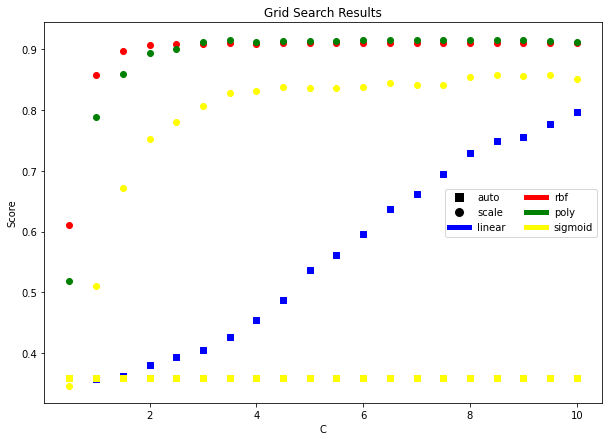

In [5]:
plt.figure(figsize=(10,7))

plt.scatter(results.query('param_kernel == "linear" and param_gamma == "auto"')['param_C'],
            results.query('param_kernel == "linear" and param_gamma == "auto"')['mean_test_score'],
            marker='s', color='blue')
plt.scatter(results.query('param_kernel == "linear" and param_gamma == "scale"')['param_C'],
            results.query('param_kernel == "linear" and param_gamma == "scale"')['mean_test_score'],
            marker='o', color='blue')
plt.scatter(results.query('param_kernel == "rbf" and param_gamma == "auto"')['param_C'],
            results.query('param_kernel == "rbf" and param_gamma == "auto"')['mean_test_score'],
            marker='s', color='red')
plt.scatter(results.query('param_kernel == "rbf" and param_gamma == "scale"')['param_C'],
            results.query('param_kernel == "rbf" and param_gamma == "scale"')['mean_test_score'],
            marker='o', color='red')
plt.scatter(results.query('param_kernel == "poly" and param_gamma == "auto"')['param_C'],
            results.query('param_kernel == "poly" and param_gamma == "auto"')['mean_test_score'],
            marker='s', color='green')
plt.scatter(results.query('param_kernel == "poly" and param_gamma == "scale"')['param_C'],
            results.query('param_kernel == "poly" and param_gamma == "scale"')['mean_test_score'],
            marker='o', color='green')
plt.scatter(results.query('param_kernel == "sigmoid" and param_gamma == "auto"')['param_C'],
            results.query('param_kernel == "sigmoid" and param_gamma == "auto"')['mean_test_score'],
            marker='s', color='yellow')
plt.scatter(results.query('param_kernel == "sigmoid" and param_gamma == "scale"')['param_C'],
            results.query('param_kernel == "sigmoid" and param_gamma == "scale"')['mean_test_score'],
            marker='o', color='yellow')

plt.xlabel("C")
plt.ylabel("Score")
plt.title("Grid Search Results")

legend = [
    plt.Line2D([0], [0], marker='s', color='white', markerfacecolor='black', markersize=10, label='auto'), 
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='black', markersize=10, label='scale'), 
    plt.Line2D([0], [0], color='blue', linewidth=5, label='linear'),
    plt.Line2D([0], [0], color='red', linewidth=5, label='rbf'),
    plt.Line2D([0], [0], color='green', linewidth=5, label='poly'),
    plt.Line2D([0], [0], color='yellow', linewidth=5, label='sigmoid')
    ]
plt.legend(handles=legend, ncols=2)

plt.show()

On voit bien que le type de noyau a un impact significatif sur les performances du modèle. Le noyau linéaire est le moins performant ce qui confirme que les données ne sont pas linéairement séparables. Les noyaux polynomial, gaussien et sigmoidal sont très similaires, mais le noyau sigmoidal est toujours moins performant.

On remarque aussi que les performances du modèle atteignent un plateau à C=2. Lorsque C>2, la différence de performance entre le noyau polynomial et le noyau gaussien n'est pas significative. Nous choisirons quand même le noyau polynomial pour la suite des tests.

Finalement, le paramètre gamma ne semble pas avoir d'influence sur les performances. Lorsque gamma est à auto, le modèle est toujours mauvais (pour rappel, gamma n'a aucun impact sur le noyau linéaire, il faut donc ignorer les points bleus).

## Évaluation

On évalue le meilleur modèle entrainé à l'aide de notre ensemble de test. Pour l'évaluation, on regarde les métriques suivantes:
- La précision ("precision") : la proportion de données appartenant réellement à leur classe prédite
- Le rappel ("recall") : la proportion des données bien classées (la justesse des prédictions pour une classe)
- Le f1-score : la moyenne harmonique de la précision et du rappel

Comme nous sommes dans une situation de classification multi-classe, on calcule ces métriques individuellement pour chaque classe. On peut ensuite regarder la distribution des résultats pour évaluer notre modèle.

### Averages ###
   - precision : 95.522% ± 10.962%
   - recall    : 93.603% ± 15.560%
   - f1_score  : 93.271% ± 11.723%
################


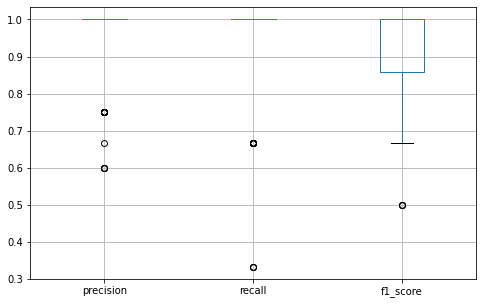

In [6]:
test_preds = grid.predict(dataset.x_test)
reports = DM.evaluate_predictions(dataset.t_test, test_preds, dataset.classes)

Comme nous avons 99 classes, il n'est pas pratique de regarder les résultats pour chacune d'entre elles. On regarde plutôt la moyenne de chaque métrique sur l'ensemble des classes. On peut alors voir que notre modèle fonctionne très bien. Il est à la fois précis et juste.

Comme on peut le voir dans le boxplot, les prédictions sont parfaites (métriques à 1.0) pour la grande majorité des classes. Il y a cependant des classes pour lesquelles le modèle a moins bien performé. Regardons de quelles classes il s'agit.

In [7]:
bad_classes = reports.query('precision < 1.0 or recall < 1.0')
print(bad_classes)
print('Sum:', len(bad_classes))

                           precision    recall  f1_score
Acer_Rubrum                 0.750000  1.000000  0.857143
Alnus_Cordata               0.750000  1.000000  0.857143
Alnus_Maximowiczii          0.750000  1.000000  0.857143
Arundinaria_Simonii         1.000000  0.666667  0.800000
Crataegus_Monogyna          1.000000  0.666667  0.800000
Eucalyptus_Glaucescens      0.600000  1.000000  0.750000
Eucalyptus_Neglecta         1.000000  0.333333  0.500000
Fagus_Sylvatica             1.000000  0.333333  0.500000
Liriodendron_Tulipifera     0.600000  1.000000  0.750000
Lithocarpus_Cleistocarpus   0.750000  1.000000  0.857143
Prunus_Avium                0.750000  1.000000  0.857143
Prunus_X_Shmittii           1.000000  0.666667  0.800000
Quercus_Afares              1.000000  0.666667  0.800000
Quercus_Agrifolia           0.750000  1.000000  0.857143
Quercus_Cerris              0.600000  1.000000  0.750000
Quercus_Coccifera           1.000000  0.666667  0.800000
Quercus_Ellipsoidalis       1.0

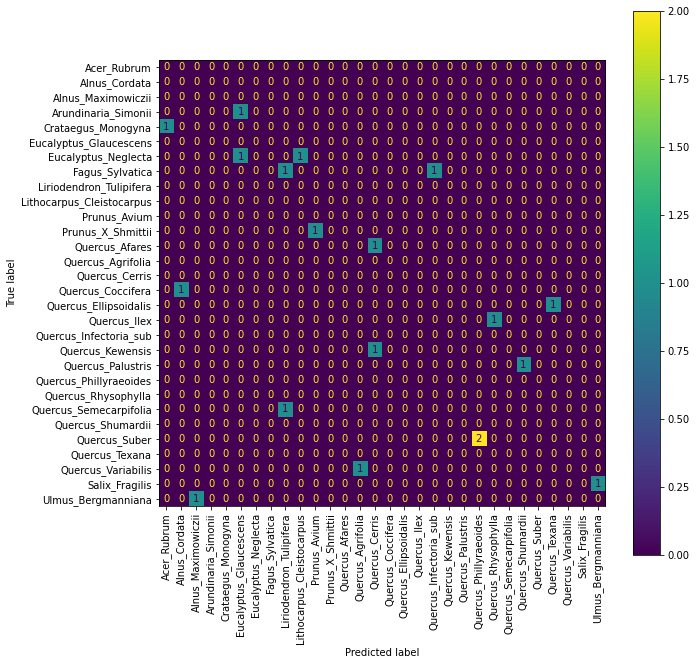

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

# Get all the wrong predictions
bad_preds = DM.extract_bad_predictions(dataset.t_test, test_preds, labels=dataset.classes, ids=dataset.id_test)

# Display them as a confusion matrix
display = ConfusionMatrixDisplay.from_predictions(bad_preds['True Class'], bad_preds['Predicted Class'], 
                                                  labels=bad_classes.index, xticks_rotation='vertical')
display.figure_.set_figwidth(10)
display.figure_.set_figheight(10)

plt.show()

Il ne semble pas y avoir de relation particulière parmis les mauvaises prédictions.

### Conclusion

Le classifieur SVM est optimal lorsqu'on utilise un noyau polynomial de degré 1 avec un paramètre de régularisation de 6. Cependant, un noyau gaussien avec le même paramètre de régularisation a des performances quasi-identique. On ne peut donc pas vraiment dire si l'un est meilleur que l'autre.

Onn doit aussi rappeler que notre jeu de données contient beaucoup de classes (99) et assez peu de données par classes (seulement 10). Notre ensemble de test lui ne contenait que 3 données par classe, ce qui est très peu. Donc il est difficile de dire si les résultats obtenus correspondent aux vraies performances du modèle.